In [2]:
# imports general modules, runs ipython magic commands
# change path in this notebook to point to repo locally
# n.b. sometimes need to run this cell twice to init the plotting paramters
%run ./setup_notebook.ipynb

In [197]:
# Path to suite2p (if git cloned to code folder rather than pip installed)
s2p_path = os.path.expanduser('~/Documents/Code/suite2p')
sys.path.append(s2p_path)

import pickle
import utils.interareal_combined_class as iac
import matplotlib.patches as patches
import copy

### Load a pickled object

In [199]:
pkl_path = '/home/rlees/mnt/qnap/pkl_files/2019-11-15_J064.pkl'

with open(pkl_path, 'rb') as f:
    session_obj = pickle.load(f)

### All the attributes in a session or experiment object

In [200]:
print('Session object attributes')
for key, value in vars(session_obj).items():
    print(key)

# There are up to four experiments:
## photostim_r - photostimulation trials with one set of targets
## photostim_s - photostimulation trials with a different set of targets
## whisker_stim - whisker stimulation of a single whisker
## spont - spontaneous imaging with no stimulations
exp_obj = session_obj.photostim_r

print('\nExperimental object attributes')
for key, value in vars(exp_obj).items():
    print(key)

Session object attributes
ss_id
sheet_name
s2p_path
photostim_r
photostim_s
whisker_stim
spont
frame_list

Experimental object attributes
tiff_path
naparm_path
paq_path
sheet_name
s2p_path
stim_channel
stim_type
fps
frame_x
frame_y
n_planes
pix_sz_x
pix_sz_y
scan_x
scan_y
zoom
n_frames
n_groups
n_reps
n_shots
n_trials
inter_point_delay
spiral_size
single_stim_dur
stim_dur
duration_frames
stim_start_frames
frames
cell_id
n_units
cell_plane
cell_med
cell_s1
cell_x
cell_y
raw
mean_img
xoff
yoff
pre_frames
post_frames
all_trials
stas
all_amplitudes
sta_amplitudes
t_tests
wilcoxons
sta_sig
sta_sig_nomulti
single_sig
n_targets
target_coords
target_areas
targeted_cells
n_targeted_cells


### Calculate the range of frames corresponding to a particular experiment

In [201]:
frame_range = exp_obj.frames

print('Number of frames in each experiment, in order:', session_obj.frame_list)
print('\nFor stim type:', exp_obj.stim_type)
print('The range of frames is:', frame_range)

Number of frames in each experiment, in order: [22986 22986 22986 22986]

For stim type: pr
The range of frames is: range(0, 22986)


### Plot a particular cell

This is the neuropil subtracted trace from suite2p for cell 180 of the dataset 
(suite2p cell id: 187)

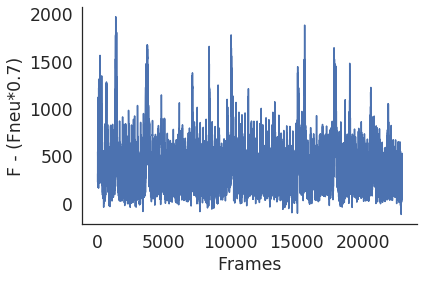

In [202]:
cell = 180

print('This is the neuropil subtracted trace from suite2p for cell', cell,
      'of the dataset \n(suite2p cell id:', exp_obj.cell_id[0][cell],
      end=')')

y = exp_obj.raw[0][cell][frame_range] #raw attribute is a plane x cell x time fluorescence trace

plt.plot(y);
plt.xlabel('Frames');
plt.ylabel('F - (Fneu*0.7)');

Replotting the x-axis as time in seconds


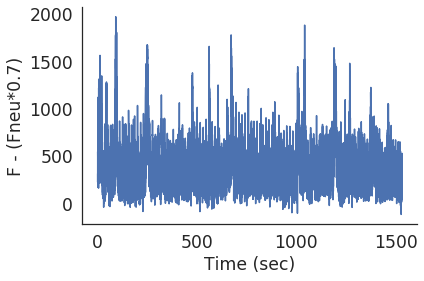

In [203]:
print('Replotting the x-axis as time in seconds')

fps = int(exp_obj.fps)
x = np.array(range(len(y)))/fps

plt.plot(x,y)
plt.xlabel('Time (sec)');
plt.ylabel('F - (Fneu*0.7)');

### Plot the peri-stimulus dFF of a particular cell as a result of photostim
#### (only for photostim exp_obj)

Total number of trials is 100 each with a stimulus duration of 6
This is a targeted cell


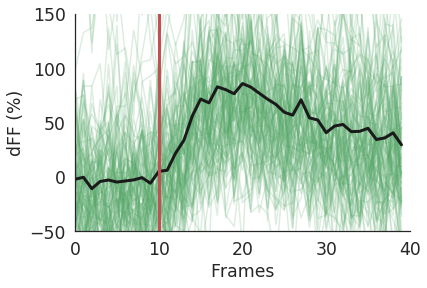

In [204]:
n_trials = exp_obj.n_trials
duration_frames = exp_obj.duration_frames
print('Total number of trials is', n_trials, 'each with a stimulus duration of', duration_frames)

if exp_obj.targeted_cells[cell] == 1:
    print('This is a targeted cell')

stim_start_frames = exp_obj.stim_start_frames

pre_frames = 10
post_frames = 30

dff = utils.dfof(exp_obj.raw[0][cell])
avg_trace = []

for frame in stim_start_frames[0]:
    y = dff[frame - pre_frames:frame + post_frames]
    avg_trace.append(y)
    plt.plot(y, 'g', alpha=0.2);

avg_trace = np.mean(np.array(avg_trace), axis=0)
plt.plot(avg_trace, 'k', lw=3)
plt.axis([0, 40, -50, 150])
plt.xlabel('Frames');
plt.ylabel('dFF (%)');

plt.plot([pre_frames] * 2, [-50, 150], 'r', lw=3);

### Plot all curated cell masks on to the mean image

Total number of cells: 1081
Image size: 1024 by 1024 pixels 
Pixel size: 1.36536549540337 by 1.36536549540337 microns


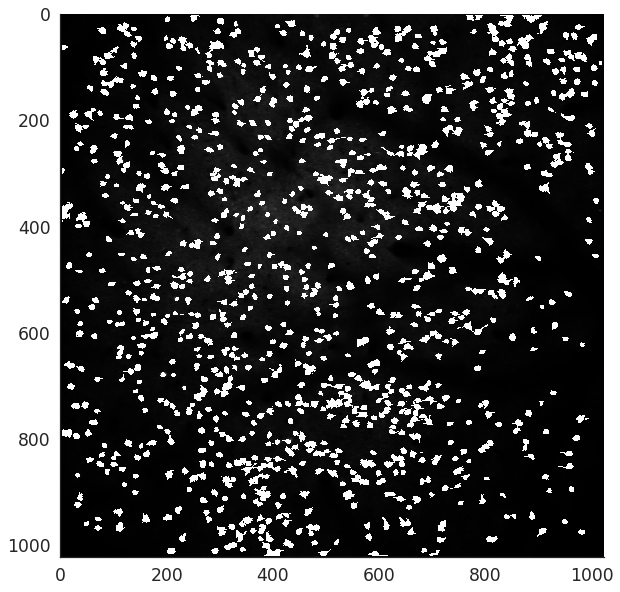

In [271]:
s2p_path = '/home/rlees/mnt/qnap/Data/2019-11-15/2019-11-15_J064/2019-11-15_J064_t-007/suite2p/plane0'

plt.figure(figsize=(10,10));
mean_img = copy.deepcopy(exp_obj.mean_img[0])

stat = np.load(os.path.join(s2p_path, 'stat.npy'), allow_pickle=True)
ops = np.load(os.path.join(s2p_path, 'ops.npy'), allow_pickle=True).item()
iscell = np.load(os.path.join(s2p_path, 'iscell.npy'), allow_pickle=True)           

for n in range(0,len(iscell)):
    if n in exp_obj.cell_id[0]:
        ypix = stat[n]['ypix']
        xpix = stat[n]['xpix']
        mean_img[ypix,xpix] = 8000
    
plt.imshow(mean_img, cmap='gray', vmin=0, vmax=8000);

print('Total number of cells:', exp_obj.n_units[0])
print('Image size:', exp_obj.frame_x, 'by', exp_obj.frame_y, 'pixels',
     '\nPixel size:', exp_obj.pix_sz_x, 'by', exp_obj.pix_sz_y, 'microns')

### Plot particular cell masks on to the mean image

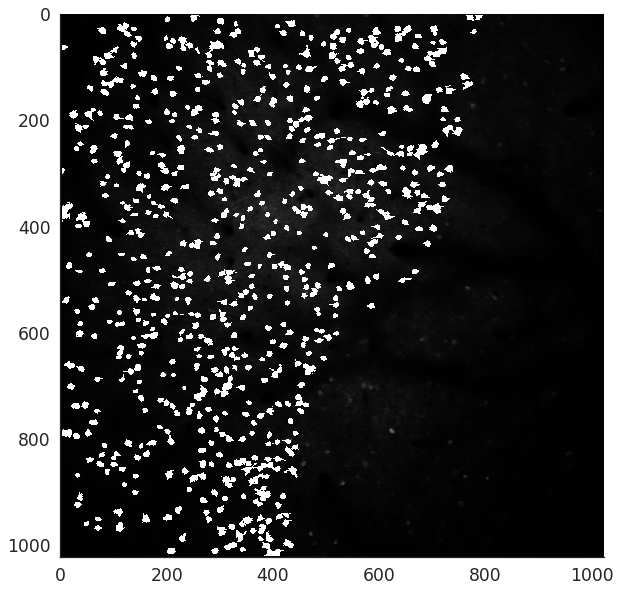

In [288]:
plt.figure(figsize=(10,10));
mean_img = copy.deepcopy(exp_obj.mean_img[0])

# S1 cells (invert for S2)
cell_ids = [exp_obj.cell_id[0][i] for i,b in enumerate(exp_obj.cell_s1[0]) if b]

# Targeted cells (invert for non-targeted)
# cell_ids = [exp_obj.cell_id[0][i] for i,b in enumerate(exp_obj.targeted_cells) if b]

for n in range(0,len(iscell)):
    if n in cell_ids:
        ypix = stat[n]['ypix']
        xpix = stat[n]['xpix']
        mean_img[ypix,xpix] = 8000
    
plt.imshow(mean_img, cmap='gray', vmin=0, vmax=8000);

### Plot already processed data (e.g. trials or stimulus-triggered average traces)

Plot of targeted cells stimulus-triggered average dFF


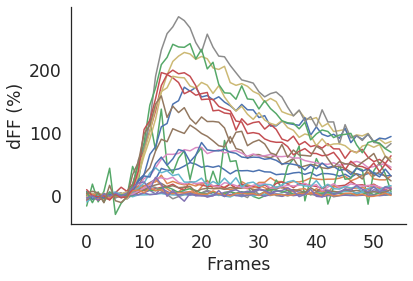

In [290]:
print('Plot of targeted cells stimulus-triggered average dFF')
targeted_cell_ids = [i for i,b in enumerate(exp_obj.targeted_cells) if b]

for cell_id in targeted_cell_ids:
    plt.plot(exp_obj.stas[0][cell_id])
    
plt.xlabel('Frames');
plt.ylabel('dFF (%)');